In [30]:
#!pip install ipywidgets
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import re
import emoji
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset

from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
from string import punctuation
from keras.preprocessing.sequence import pad_sequences

In [92]:
import sklearn

sklearn_version = sklearn.__version__
print(sklearn_version)


1.2.2


In [31]:
# Adapted from https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# LSTM

In [32]:
def hashtag(text):
  FLAGS = re.MULTILINE | re.DOTALL
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " 

def clean_data(text):
  FLAGS = re.MULTILINE | re.DOTALL
  eyes = r"[8:=;]"
  nose = r"['`\-]?"
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)

  text = emoji.demojize(text)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\w+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
  text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
  text = re_sub(r"  ", r" ")
  text = re_sub(r" ([A-Z]){2,} ", allcaps)
  text = word_tokenize(text.lower())
  text = [token for token in text if token not in punctuation and token not in STOPWORDS]
  return text

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['text']:
    temp_list.append(clean_data(t))
  tweet_df['clean_text'] = temp_list
  return tweet_df

In [33]:
train_df = pd.read_csv("data/train_2024.csv", quoting=3)
test_df = pd.read_csv("data/dev_2024.csv", quoting=3)
eval_df = pd.read_csv("data/test_2024.csv", quoting=3)

In [34]:
train_df = preprocessing_tweet(train_df)
test_df = preprocessing_tweet(test_df)
eval_df['label'] = 0
eval_df = preprocessing_tweet(eval_df)

train_df.head()

,id,text,label,clean_text
0,0,Except that Desmond played first base last nig...,0,"[desmond, played, base, night, tapia, lf, allc..."
1,1,What i find funny is the loyalty and blindness...,0,"[funny, loyalty, blindness, english, community..."
2,2,Read the article not just the headline & you ...,0,"[read, article, headline]"
3,3,Speaking of a horses backside is that where y...,1,"[speaking, horses, backside, head]"
4,4,Michael Barone- gee are you dumb. No other wo...,1,"[michael, barone-, gee, dumb, words, needed]"


In [35]:
from collections import Counter

vocab = {}
word_freq = Counter()

# Count word frequencies and build vocab
for tweet in train_df["clean_text"]:
    for word in tweet:
        word_freq[word] += 1

# Assign indices to words based on frequency
vocab_index = 1
for word, freq in word_freq.items():
    vocab[word] = vocab_index
    vocab_index += 1

# Add 'UNK' for unknown words
vocab['UNK'] = len(vocab) + 1

In [36]:
vocab = {}
reverse_vocab = {}
vocab_index = 1
for tweet in train_df["clean_text"]:
    for word in tweet:
        if word not in vocab:
            vocab[word] = vocab_index
            vocab_index += 1
vocab['UNK'] = len(vocab) + 1

In [37]:
def gen_seq(df):
    x = []
    for tweet in df["clean_text"]:
        seq = []
        for word in tweet:
            seq.append(vocab.get(word, vocab['UNK']))
        x.append(seq)
    df["seq"] = x

gen_seq(train_df)
gen_seq(test_df)
gen_seq(eval_df)

In [38]:
max_seq_length = train_df['seq'].apply(len).max()
print(max_seq_length)
pad_length = 64

train_df['seq_padded'] = train_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
test_df['seq_padded'] = test_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
eval_df['seq_padded'] = eval_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]

308


In [39]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx]['seq_padded']
        label = self.dataframe.iloc[idx]['label']
        return torch.tensor(sequence), torch.tensor(label)

trainset = CustomDataset(train_df)
testset = CustomDataset(test_df)
evalset = CustomDataset(eval_df)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=False)

In [40]:
def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print('Model loaded from %s.' % filename)
    model.to(device)
    model.eval()

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = 100 # 256
        self.no_layers = 2 # 2
        self.embedding = nn.Embedding(num_embeddings=len(vocab)+1, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=self.no_layers, batch_first = True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(in_features=self.hidden_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_sz = x.shape[0]
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        # Assuming we only care about the output of the last time step
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(batch_sz, -1)
        x = x[:, -1]
        return x, hidden
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [42]:
lstm_model = LSTMModel(pad_length)
lstm_model.to(device)

LSTMModel(
  (embedding): Embedding(78560, 64)
  (lstm): LSTM(64, 100, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
load_model(lstm_model, 'model/lstm.pth', device)
sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

Model loaded from lstm.pth.


5175141

In [44]:
lstm_train_pred = []
lstm_test_pred = []
lstm_eval_pred = []

h = lstm_model.init_hidden(batch_size)
for data in trainloader:
    x_train, _ = data
    x_train = x_train.to(device)
    y_pred = lstm_model.forward(x_train, h)[0][0]
    lstm_train_pred.append(y_pred.cpu().data.numpy().item())

for data in testloader:
    x_test, _ = data
    x_test = x_test.to(device)
    y_pred = lstm_model.forward(x_test, h)[0][0]
    lstm_test_pred.append(y_pred.cpu().data.numpy().item())

for data in evalloader:
    x_val, _ = data
    x_val = x_val.to(device)
    y_pred = lstm_model.forward(x_val, h)[0][0]
    lstm_eval_pred.append(y_pred.cpu().data.numpy().item())

In [45]:
lstm_train_pred = [np.round(y) for y in lstm_train_pred]
lstm_test_pred = [np.round(y) for y in lstm_test_pred]
lstm_eval_pred = [np.round(y) for y in lstm_eval_pred]

Train accuracy: 0.9592424242424242
Train precision: 0.9590287898369401
Train recall: 0.9319918764363209
Train F1 score: 0.9453170526772282


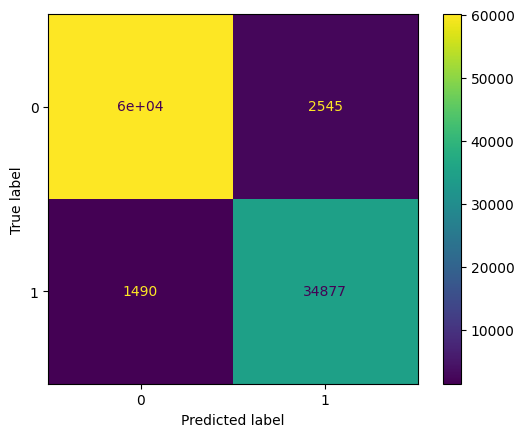

In [46]:
lstm_y_train = train_df['label'].tolist()

print("Train accuracy:", accuracy_score(lstm_train_pred, lstm_y_train))
print("Train precision:", precision_score(lstm_train_pred, lstm_y_train))
print("Train recall:", recall_score(lstm_train_pred, lstm_y_train))
print("Train F1 score:", f1_score(lstm_train_pred, lstm_y_train))
conf_mat = confusion_matrix(lstm_y_train, lstm_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.9161818181818182
Test precision: 0.9027882441597589
Test recall: 0.8704286752240252
Test F1 score: 0.8863131935881627


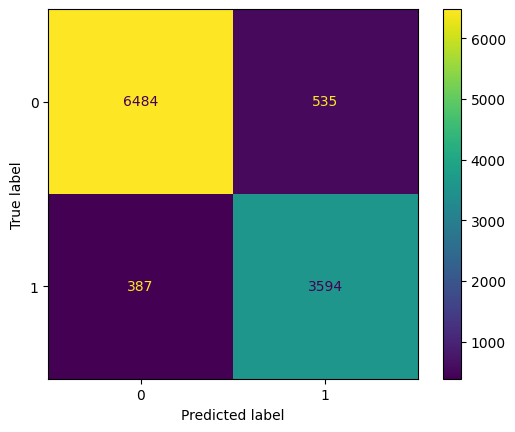

In [47]:
lstm_y_test = test_df['label'].tolist()

print("Test accuracy:", accuracy_score(lstm_test_pred, lstm_y_test))
print("Test precision:", precision_score(lstm_test_pred, lstm_y_test))
print("Test recall:", recall_score(lstm_test_pred, lstm_y_test))
print("Test F1 score:", f1_score(lstm_test_pred, lstm_y_test))
conf_mat = confusion_matrix(lstm_y_test, lstm_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [48]:
differing_indices = [i for i, (x, y) in enumerate(zip(lstm_test_pred, lstm_y_test)) if x != y]

In [49]:
test_df[["text", "label"]].iloc[differing_indices]

,text,label
31,���I ain���t drunk.��� ���Then you���re mad; t...,1
49,Mm. That tastes like balls.,0
51,Do you fell better now ready to put the pacif...,1
61,Wow. What a hateful person you seem to be. I t...,1
62,Except for Alaska were the USA has used F-16s ...,0
...,...,...
10917,These are Ossoff's peeps. He should embrace t...,1
10935,First: Chunky Punk could never out run anyone ...,1
10965,He’s just a dirty peasant who doesn’t know any...,1
10984,Aw come on we all know there's no way in hell...,0


# CNN

In [50]:
def hashtag(text):
  FLAGS = re.MULTILINE | re.DOTALL
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " 

def clean_data(text):
  FLAGS = re.MULTILINE | re.DOTALL
  eyes = r"[8:=;]"
  nose = r"['`\-]?"
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)

  text = emoji.demojize(text)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\w+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
  text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
  text = re_sub(r"  ", r" ")
  text = re_sub(r" ([A-Z]){2,} ", allcaps)
  text = word_tokenize(text.lower())
  text = [token for token in text if token not in punctuation and token not in STOPWORDS]
  return text

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['text']:
    temp_list.append(clean_data(t))
  tweet_df['clean_text'] = temp_list
  return tweet_df

In [51]:
train_df = pd.read_csv("data/train_2024.csv", quoting=3)
test_df = pd.read_csv("data/dev_2024.csv", quoting=3)
eval_df = pd.read_csv("data/test_2024.csv", quoting=3)

In [52]:
train_df = preprocessing_tweet(train_df)
test_df = preprocessing_tweet(test_df)
eval_df['label'] = 0
eval_df = preprocessing_tweet(eval_df)

train_df.head()

,id,text,label,clean_text
0,0,Except that Desmond played first base last nig...,0,"[desmond, played, base, night, tapia, lf, allc..."
1,1,What i find funny is the loyalty and blindness...,0,"[funny, loyalty, blindness, english, community..."
2,2,Read the article not just the headline & you ...,0,"[read, article, headline]"
3,3,Speaking of a horses backside is that where y...,1,"[speaking, horses, backside, head]"
4,4,Michael Barone- gee are you dumb. No other wo...,1,"[michael, barone-, gee, dumb, words, needed]"


In [53]:
from collections import Counter

vocab = {}
word_freq = Counter()

# Count word frequencies and build vocab
for tweet in train_df["clean_text"]:
    for word in tweet:
        word_freq[word] += 1

# Assign indices to words based on frequency
vocab_index = 1
for word, freq in word_freq.items():
    vocab[word] = vocab_index
    vocab_index += 1

# Add 'UNK' for unknown words
vocab['UNK'] = len(vocab) + 1

In [54]:
vocab = {}
reverse_vocab = {}
vocab_index = 1
for tweet in train_df["clean_text"]:
    for word in tweet:
        if word not in vocab:
            vocab[word] = vocab_index
            vocab_index += 1
vocab['UNK'] = len(vocab) + 1

In [55]:
def gen_seq(df):
    x = []
    for tweet in df["clean_text"]:
        seq = []
        for word in tweet:
            seq.append(vocab.get(word, vocab['UNK']))
        x.append(seq)
    df["seq"] = x

gen_seq(train_df)
gen_seq(test_df)
gen_seq(eval_df)

In [56]:
max_seq_length = train_df['seq'].apply(len).max()
print(max_seq_length)
pad_length = 64

train_df['seq_padded'] = train_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
test_df['seq_padded'] = test_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]
eval_df['seq_padded'] = eval_df['seq'].apply(lambda x: pad_sequences([x], padding='post', maxlen=pad_length)).str[0]

308


In [57]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx]['seq_padded']
        label = self.dataframe.iloc[idx]['label']
        return torch.tensor(sequence), torch.tensor(label)

trainset = CustomDataset(train_df)
testset = CustomDataset(test_df)
evalset = CustomDataset(eval_df)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=False)

In [58]:
import torch.nn.functional as F
n_filters = 1000
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
class CNNModel(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab)+1, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[0],embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[1],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(FILTER_SIZES[2],embedding_dim))
        self.fc = nn.Linear(len(FILTER_SIZES)*n_filters, OUTPUT_DIM )
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        embedded = self.embedding(x)
                
        
        embedded = embedded.unsqueeze(1)
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return torch.sigmoid(self.fc(cat))
    

In [59]:
def compute_loss_and_accuracy(model, loader, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.float().to(device)
            outputs = model.forward(x)
            loss = criterion(outputs, y)
            losses.append(loss.cpu().numpy())
            predicted = torch.round(outputs)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return np.mean(losses), correct / total

def print_progress(epoch, train_loss, train_accuracy, val_loss, val_accuracy):
    print('Epoch {}: Train loss: {:.4f}, Train accuracy: {:.4f}, Val loss: {:.4f}, Val accuracy {:.4f}'.format(
        epoch, train_loss, train_accuracy, val_loss, val_accuracy))
    
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [60]:
#embedding_dim = max_seq_length
embedding_dim = pad_length
cnn_model = CNNModel(embedding_dim)
cnn_model.to(device)

CNNModel(
  (embedding): Embedding(78560, 64)
  (conv_0): Conv2d(1, 1000, kernel_size=(3, 64), stride=(1, 1))
  (conv_1): Conv2d(1, 1000, kernel_size=(4, 64), stride=(1, 1))
  (conv_2): Conv2d(1, 1000, kernel_size=(5, 64), stride=(1, 1))
  (fc): Linear(in_features=3000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [61]:
def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print('Model loaded from %s.' % filename)
    model.to(device)
    model.eval()

In [62]:
load_model(cnn_model, 'model/cnn.pth', device)
sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

Model loaded from cnn.pth.


5801841

In [63]:
cnn_train_pred = []
cnn_test_pred = []
cnn_eval_pred = []

for data in trainloader:
    x_train, _ = data
    x_train = x_train.to(device)
    y_pred = cnn_model.forward(x_train)[0][0]
    cnn_train_pred.append(y_pred.cpu().data.numpy().item())

for data in testloader:
    x_test, _ = data
    x_test = x_test.to(device)
    y_pred = cnn_model.forward(x_test)[0][0]
    cnn_test_pred.append(y_pred.cpu().data.numpy().item())

for data in evalloader:
    x_val, _ = data
    x_val = x_val.to(device)
    y_pred = cnn_model.forward(x_val)[0][0]
    cnn_eval_pred.append(y_pred.cpu().data.numpy().item())

In [64]:
cnn_train_pred = [np.round(y) for y in cnn_train_pred]
cnn_test_pred = [np.round(y) for y in cnn_test_pred]
cnn_eval_pred = [np.round(y) for y in cnn_eval_pred]

Train accuracy: 0.9505757575757576
Train precision: 0.9359034289328237
Train recall: 0.9299961746543527
Train F1 score: 0.932940450901117


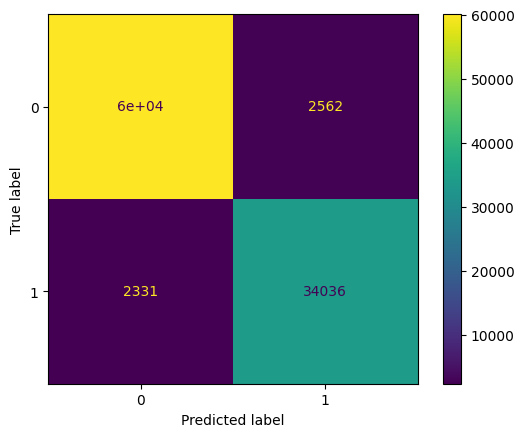

In [65]:
cnn_y_train = train_df['label'].tolist()

print("Train accuracy:", accuracy_score(cnn_train_pred, cnn_y_train))
print("Train precision:", precision_score(cnn_train_pred, cnn_y_train))
print("Train recall:", recall_score(cnn_train_pred, cnn_y_train))
print("Train F1 score:", f1_score(cnn_train_pred, cnn_y_train))
conf_mat = confusion_matrix(cnn_y_train, cnn_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.9240909090909091
Test precision: 0.8982667671439337
Test recall: 0.8926610084872691
Test F1 score: 0.8954551145611619


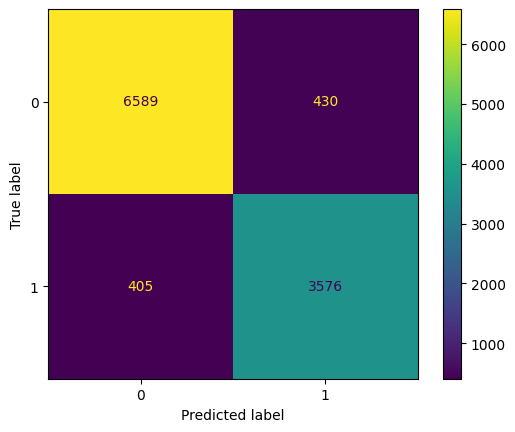

In [66]:
cnn_y_test = test_df['label'].tolist()

print("Test accuracy:", accuracy_score(cnn_test_pred, cnn_y_test))
print("Test precision:", precision_score(cnn_test_pred, cnn_y_test))
print("Test recall:", recall_score(cnn_test_pred, cnn_y_test))
print("Test F1 score:", f1_score(cnn_test_pred, cnn_y_test))
conf_mat = confusion_matrix(cnn_y_test, cnn_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [67]:
differing_indices = [i for i, (x, y) in enumerate(zip(cnn_test_pred, cnn_y_test)) if x != y]

In [68]:
test_df[["text", "label"]].iloc[differing_indices]

,text,label
31,���I ain���t drunk.��� ���Then you���re mad; t...,1
49,Mm. That tastes like balls.,0
51,Do you fell better now ready to put the pacif...,1
61,Wow. What a hateful person you seem to be. I t...,1
63,The Trump base: deluded and delusional.,1
...,...,...
10847,What an a$$hole you are.,1
10850,I'm with you on this point singlespey. My wif...,0
10875,Ironic is it not that those filthy squalid u...,0
10894,If I were in the business I am speaking about ...,0


# BERT

In [69]:
from transformers import BertTokenizer, TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import DistilBertTokenizerFast
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [70]:
def hashtag(text):
  FLAGS = re.MULTILINE | re.DOTALL
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " 

def clean_data(text):
  FLAGS = re.MULTILINE | re.DOTALL
  eyes = r"[8:=;]"
  nose = r"['`\-]?"
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)

  text = emoji.demojize(text)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\w+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
  text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
  text = re_sub(r"  ", r" ")
  text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
  return text.lower()

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['text']:
    temp_list.append(clean_data(t))
  tweet_df['clean_text'] = temp_list
  return tweet_df

In [72]:
train_df = pd.read_csv("data/train_2024.csv", quoting=3)
test_df = pd.read_csv("data/dev_2024.csv", quoting=3)
eval_df = pd.read_csv("data/test_2024.csv", quoting=3)
eval_df['label'] = 0
train_df.head()

,id,text,label
0,0,Except that Desmond played first base last nig...,0
1,1,What i find funny is the loyalty and blindness...,0
2,2,Read the article not just the headline & you ...,0
3,3,Speaking of a horses backside is that where y...,1
4,4,Michael Barone- gee are you dumb. No other wo...,1


In [73]:
train_df = preprocessing_tweet(train_df)
test_df = preprocessing_tweet(test_df)
eval_df = preprocessing_tweet(eval_df)
train_df.head()

,id,text,label,clean_text
0,0,Except that Desmond played first base last nig...,0,except that desmond played first base last nig...
1,1,What i find funny is the loyalty and blindness...,0,what i find funny is the loyalty and blindness...
2,2,Read the article not just the headline & you ...,0,read the article not just the headline & you w...
3,3,Speaking of a horses backside is that where y...,1,speaking of a horses backside is that where yo...
4,4,Michael Barone- gee are you dumb. No other wo...,1,michael barone- gee are you dumb . no other wo...


In [74]:
def extract_tweet_and_y(raw_data_df):
  tweet, target = raw_data_df['clean_text'].tolist(), raw_data_df['label'].tolist()
  return tweet, target

In [75]:
X_train, y_train = extract_tweet_and_y(train_df)
X_test, y_test = extract_tweet_and_y(test_df)
X_eval, y_eval = extract_tweet_and_y(eval_df)

In [76]:
max_length = 256

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

train_tokens = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    return_tensors='pt'
)

test_tokens = tokenizer.batch_encode_plus(
    X_test,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    return_tensors='pt'
)

eval_tokens = tokenizer(X_eval,
                       add_special_tokens=True,
                       pad_to_max_length=True,
                       return_attention_mask=True,
                       max_length=max_length,
                       return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [77]:
train_dataset = TensorDataset(train_tokens['input_ids'], 
                              train_tokens['attention_mask'],
                              torch.tensor(y_train))

test_dataset = TensorDataset(test_tokens['input_ids'],
                             test_tokens['attention_mask'],
                             torch.tensor(y_test))

eval_dataset = TensorDataset(eval_tokens['input_ids'],
                            eval_tokens['attention_mask'],
                            torch.tensor(y_eval))


In [78]:
from transformers import BertForSequenceClassification

In [79]:
bert_model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
bert_model.load_state_dict(torch.load("model/pytorch_bert_big_train.h5", map_location=device))

<All keys matched successfully>

In [81]:
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [82]:
sum(p.numel() for p in bert_model.parameters() if p.requires_grad)

109483778

In [83]:
from torch.utils.data import DataLoader

In [84]:
batch_size = 1
dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False
)

# RandomSampler removed to allow for repeatable evaluations
dataloader_test = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

dataloader_eval = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [85]:
def evaluate(dataloader_val):

    bert_model.eval()
    
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            
        logits = outputs[1]

        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return predictions, true_vals

In [ ]:
train_y_pred, train_y_true = evaluate(dataloader_train)
test_y_pred, test_y_true = evaluate(dataloader_test)
eval_y_pred, _ = evaluate(dataloader_eval)

In [ ]:
# Convert to classes 0 or 1
bert_train_pred = np.argmax(train_y_pred, axis=1)
print(len(bert_train_pred))
print(bert_train_pred[0:20])
print(train_y_true[0:20])
print(np.array(y_train[0:20]))

bert_test_pred = np.argmax(test_y_pred, axis=1)
print(len(bert_test_pred))
print(bert_test_pred[0:20])
print(test_y_true[0:20])
print(np.array(y_test[0:20]))

bert_eval_pred = np.argmax(eval_y_pred, axis=1)
print(len(bert_eval_pred))
print(bert_eval_pred[0:20])

99000
[0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0]
[0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0]
[0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0]
11000
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]
12001
[1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1]


Train accuracy: 0.9712727272727273
Train precision: 0.9806142931778811
Train recall: 0.9434141953916563
Train F1 score: 0.9616546219393809


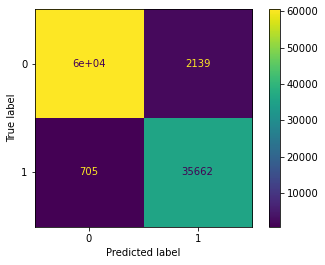

In [ ]:
bert_y_train = train_df['label'].tolist()

print("Train accuracy:", accuracy_score(bert_train_pred, bert_y_train))
print("Train precision:", precision_score(bert_train_pred, bert_y_train))
print("Train recall:", recall_score(bert_train_pred, bert_y_train))
print("Train F1 score:", f1_score(bert_train_pred, bert_y_train))
conf_mat = confusion_matrix(bert_y_train, bert_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.9502727272727273
Test precision: 0.9565435820145692
Test recall: 0.9105691056910569
Test F1 score: 0.9329903221854711


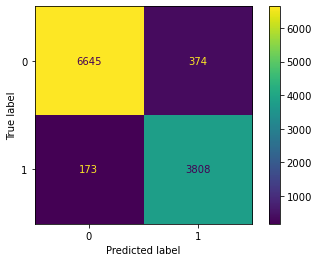

In [ ]:
bert_y_test = test_df['label'].tolist()

print("Test accuracy:", accuracy_score(bert_test_pred, bert_y_test))
print("Test precision:", precision_score(bert_test_pred, bert_y_test))
print("Test recall:", recall_score(bert_test_pred, bert_y_test))
print("Test F1 score:", f1_score(bert_test_pred, bert_y_test))
conf_mat = confusion_matrix(bert_y_test, bert_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
import csv

# Define the CSV file path
csv_file = "group6_bert_submission.csv"

# Write the labels to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'label'])  # Write the header
    for idx, label in enumerate(bert_eval_pred):
        writer.writerow([idx, label])

# BERT-LSTM-CNN-Ensemble

In [ ]:
from scipy.stats import mode

train_stack = np.stack((bert_train_pred, lstm_train_pred, cnn_train_pred), axis = 0)
test_stack = np.stack((bert_test_pred, lstm_test_pred, cnn_test_pred), axis = 0)
eval_stack = np.stack((bert_eval_pred, lstm_eval_pred, cnn_eval_pred), axis = 0)

ensemble_train_pred = mode(train_stack, axis=0)[0][0]
ensemble_test_pred = mode(test_stack, axis=0)[0][0]
ensemble_eval_pred = mode(eval_stack, axis=0)[0][0]

Train accuracy: 0.9676666666666667
Train precision: 0.9690378639975802
Train recall: 0.9443938257047915
Train F1 score: 0.9565571434387851


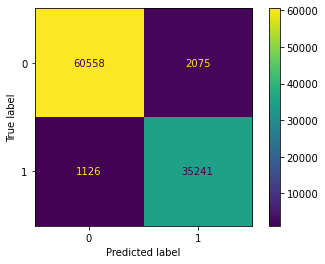

In [ ]:
ensemble_y_train = train_df['label'].tolist()

print("Train accuracy:", accuracy_score(ensemble_train_pred, ensemble_y_train))
print("Train precision:", precision_score(ensemble_train_pred, ensemble_y_train))
print("Train recall:", recall_score(ensemble_train_pred, ensemble_y_train))
print("Train F1 score:", f1_score(ensemble_train_pred, ensemble_y_train))
conf_mat = confusion_matrix(ensemble_y_train, ensemble_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.9391818181818182
Test precision: 0.9253956292388847
Test recall: 0.908284023668639
Test F1 score: 0.9167599850690556


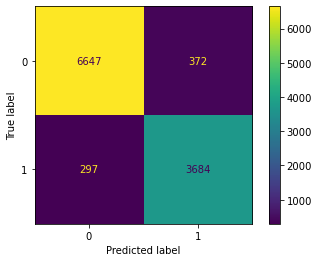

In [ ]:
ensemble_y_test = test_df['label'].tolist()

print("Test accuracy:", accuracy_score(ensemble_test_pred, ensemble_y_test))
print("Test precision:", precision_score(ensemble_test_pred, ensemble_y_test))
print("Test recall:", recall_score(ensemble_test_pred, ensemble_y_test))
print("Test F1 score:", f1_score(ensemble_test_pred, ensemble_y_test))
conf_mat = confusion_matrix(ensemble_y_test, ensemble_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
differing_indices = [i for i, (x, y) in enumerate(zip(ensemble_test_pred, ensemble_y_test)) if x != y]

In [ ]:
test_df[["text", "label"]].iloc[differing_indices]

,text,label
31,���I ain���t drunk.��� ���Then you���re mad; t...,1
49,Mm. That tastes like balls.,0
51,Do you fell better now ready to put the pacif...,1
61,Wow. What a hateful person you seem to be. I t...,1
71,i'll be darn you wouldn't think that close tha...,0
...,...,...
10829,Nobody in Anchorage wants to go to Fairbanks i...,0
10847,What an a$$hole you are.,1
10875,Ironic is it not that those filthy squalid u...,0
10894,If I were in the business I am speaking about ...,0


# BOW

In [ ]:
bow_train_pred_df = pd.read_csv("bow_train_results.csv")
bow_test_pred_df = pd.read_csv("bow_test_results.csv")
bow_train_pred_df.head()

,Unnamed: 0,preds_w_best_thres,toxic_p,not_toxic_p
0,0,False,0.407992,0.546016
1,1,False,0.629924,0.667783
2,2,False,0.671212,0.756170
3,3,True,0.531671,0.505281
4,4,True,0.596294,0.574915


In [ ]:
bow_train_pred = bow_train_pred_df["preds_w_best_thres"].tolist()
bow_train_pred = [int(boolean) for boolean in bow_train_pred]
bow_test_pred = bow_test_pred_df["preds_w_best_thres"].tolist()
bow_test_pred = [int(boolean) for boolean in bow_test_pred]

Train accuracy: 0.8550707070707071
Train precision: 0.7392141226936508
Train recall: 0.8467886729454752
Train F1 score: 0.7893531432598291


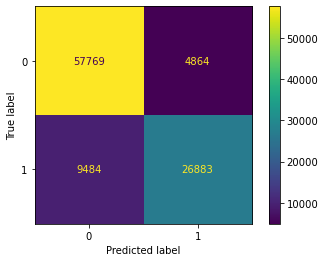

In [ ]:
bow_y_train = train_df['label'].tolist()

print("Train accuracy:", accuracy_score(bow_train_pred, bow_y_train))
print("Train precision:", precision_score(bow_train_pred, bow_y_train))
print("Train recall:", recall_score(bow_train_pred, bow_y_train))
print("Train F1 score:", f1_score(bow_train_pred, bow_y_train))
conf_mat = confusion_matrix(bow_y_train, bow_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

Test accuracy: 0.8321818181818181
Test precision: 0.6983170057774428
Test recall: 0.8116788321167884
Test F1 score: 0.7507426411018093


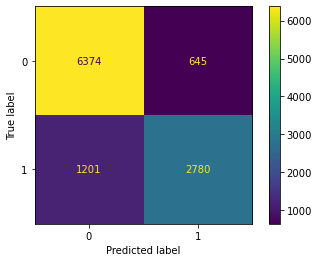

In [ ]:
bow_y_test = test_df['label'].tolist()

print("Test accuracy:", accuracy_score(bow_test_pred, bow_y_test))
print("Test precision:", precision_score(bow_test_pred, bow_y_test))
print("Test recall:", recall_score(bow_test_pred, bow_y_test))
print("Test F1 score:", f1_score(bow_test_pred, bow_y_test))
conf_mat = confusion_matrix(bow_y_test, bow_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()